# Disease Symptoms Prediction Model

### **Project Goal**

**Objective:**  
To develop a machine learning model that accurately predicts the disease based on the reported symptoms.

**Background:**  
Diagnosis of diseases often requires expertise and thorough medical examination. However, for common ailments or as a preliminary diagnostic tool, we aim to utilize symptom data to predict potential diseases. This tool can assist healthcare professionals as a reference, guide patients in understanding their conditions, or even help in telemedicine where immediate physical diagnosis isn't feasible.

**Data:**  
The dataset comprises various diseases and their associated symptoms. Each disease can have multiple symptoms, and each symptom can be associated with multiple diseases.

**Expected Outcomes:**  
1. A robust model that can predict the disease based on the given symptoms.
2. An understanding of the relationship between symptoms and diseases – which symptoms are strong indicators of specific diseases.
3. A baseline comparison to understand the efficacy of our model.

**Constraints:**  
1. The model is not a replacement for professional medical advice. It's a supplementary tool to assist in understanding symptoms.
2. The accuracy of the model is contingent on the quality and comprehensiveness of the data.

**Next Steps:**  
Upon achieving satisfactory model performance, we aim to:
1. Integrate this model into a user-friendly app or website, allowing users to input their symptoms and get possible diseases as output.
2. Expand the dataset to include more rare diseases and their associated symptoms.
3. Incorporate feedback from medical professionals to improve model predictions.

In [1]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from itertools import chain
from nltk.util import ngrams
from collections import Counter
from sklearn.utils import resample
from scipy.stats import chi2_contingency
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

warnings.filterwarnings('ignore')

## Acquire

#### Dataset Structure:

- **Rows**: 4920
- **Columns**: 18

In [2]:
df = pd.read_csv('dataset.csv')

In [3]:
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.shape

(4920, 18)

## Prepare:

### Data Preprocessing

Converting the dataset into a format suitable for machine learning:

1. Convert symptom columns to consistent data types.
2. One-hot encode each symptom column.
3. Aggregate the one-hot encoded columns to remove duplicates.
4. Construct the final dataset combining diseases and their respective symptoms.

In [5]:
# Convert symptom columns to string type for consistent data type
df[df.columns[1:]] = df[df.columns[1:]].astype(str)

### One-hot encoding each symptom column.

In [6]:
# One-hot encode each symptom column
encoded_list = [pd.get_dummies(df[col], prefix="", prefix_sep="") for col in df.columns[1:]]
encoded_df = pd.concat(encoded_list, axis=1)

### Aggregating duplicates to ensure each symptom is represented only once in our final dataset.

In [7]:
# Aggregate the one-hot encoded columns to remove duplicates
encoded_df = encoded_df.groupby(encoded_df.columns, axis=1).sum().clip(upper=1)

### Merging the encoded symptoms with their respective diseases to get our preprocessed dataset.

In [8]:
# Concatenate the Disease column with the aggregated symptoms
df_final = pd.concat([df["Disease"], encoded_df], axis=1)

In [9]:
# Drop the 'nan' column that resulted from the NaN values in the original dataset
df_final = df_final.drop(columns='nan')

In [10]:
df_final.head()

,Disease,abdominal_pain,abnormal_menstruation,acidity,acute_liver_failure,altered_sensorium,anxiety,back_pain,belly_pain,blackheads,...,watering_from_eyes,weakness_in_limbs,weakness_of_one_body_side,weight_gain,weight_loss,yellow_crust_ooze,yellow_urine,yellowing_of_eyes,yellowish_skin,itching
0,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Explore

### Data Splitting for Training, Validation, and Testing

To evaluate the performance of our machine learning models, we split our dataset into three subsets:

1. **Training set (60%)**
2. **Validation set (20%)**
3. **Test set (20%)**

In [11]:
# Split the data into training (60%) and a temporary set (40%), ensuring class distribution remains consistent using stratification
train, temp = train_test_split(df_final, test_size=0.4, stratify=df_final['Disease'], random_state=42)

# Split the temporary set into validation (20%) and test sets (20%) with stratification
val, test = train_test_split(temp, test_size=0.5, stratify=temp['Disease'], random_state=42)

# Print the shapes of the train, validation, and test sets
train.shape, val.shape, test.shape

((2952, 132), (984, 132), (984, 132))

## What is the distribution of diseases in the dataset?

#### Visualizing the Distribution of the Most Frequent Diseases in Training Data

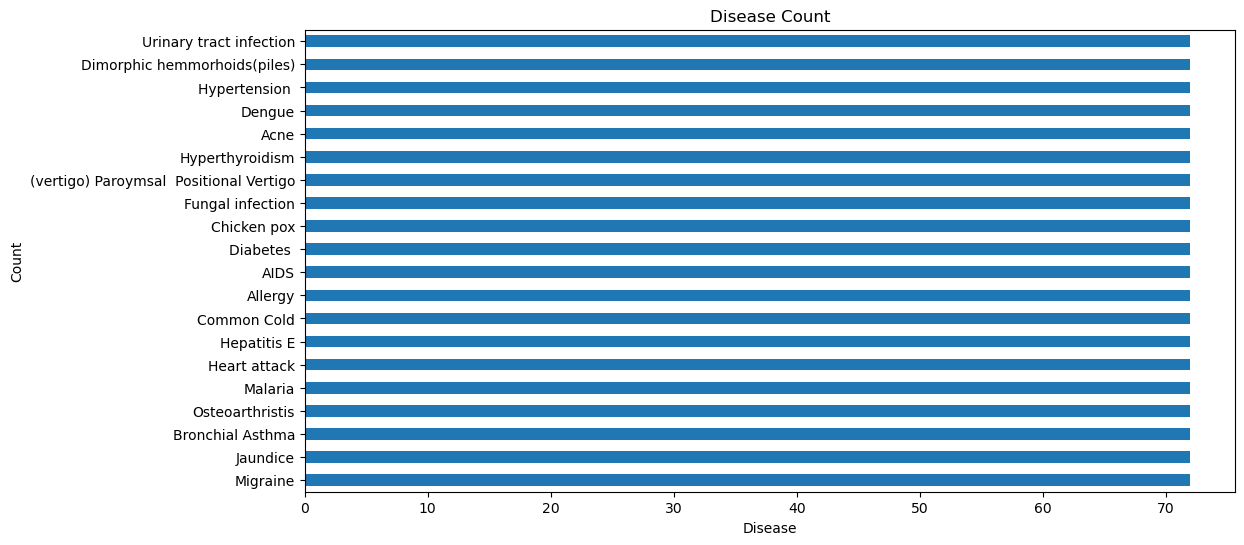

In [12]:
disease_counts = train['Disease'].value_counts().head(20)
disease_counts.plot(kind='barh', figsize=(12, 6))
plt.title("Disease Count")
plt.ylabel("Count")
plt.xlabel("Disease")
plt.show()

### Top 20 Symptom Frequency Bar Chart

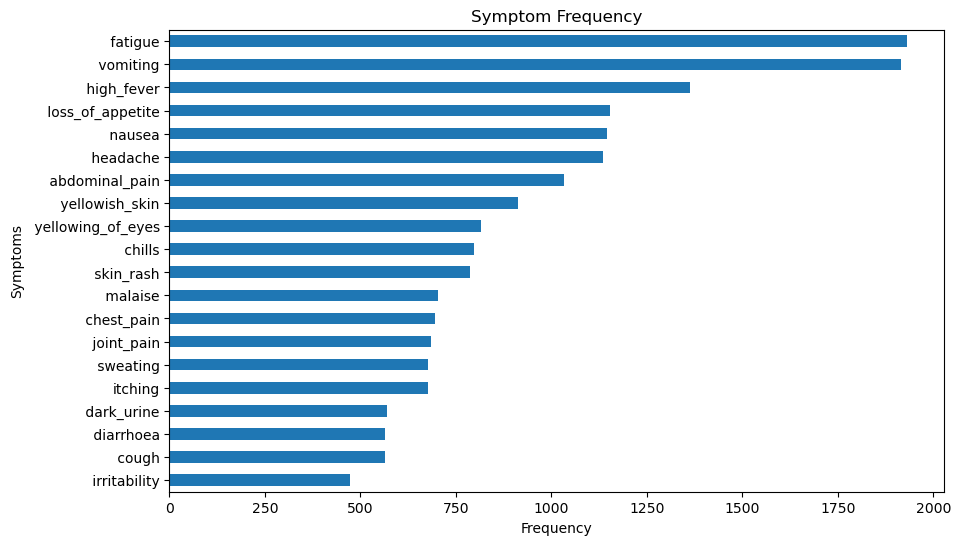

In [13]:
# Exclude 'Disease' column and sum occurrences of each symptom, excluding NaN values
symptom_counts = df_final.drop(columns='Disease').apply(lambda x: x.value_counts().get(1, 0))

# Plot the top 20 symptoms based on their frequency
plt.figure(figsize=(10, 6))
symptom_counts.sort_values(ascending=True).tail(20).plot(kind='barh')
plt.title("Symptom Frequency")
plt.xlabel("Frequency")
plt.ylabel("Symptoms")
plt.show()

### Top 20 Symptom Frequency Bar Chart Insights:

1. **Dominant Symptoms**: The most prevalent symptom in the dataset is "fever". This suggests that fever is a common symptom across a variety of diseases or conditions.
  
2. **Common Ailments**: Symptoms like "cough", "headache", and "fatigue" are also frequently mentioned, indicating that respiratory and general malaise symptoms are prevalent in the dataset.
  
3. **Specific Indicators**: The presence of more specific symptoms like "jaundice" (yellowing of the skin or eyes) suggests the dataset may contain descriptions of diseases that affect the liver or bile production.
  
4. **Digestive Issues**: With "vomiting" and "diarrhea" ranking high on the chart, gastrointestinal symptoms seem to be a significant concern in the diseases or conditions represented.
  
5. **Variety of Symptoms**: The wide range of symptoms, from general (like "pain") to specific (like "rash"), indicates a comprehensive dataset that encompasses a variety of ailments and diseases.

### Visualizing Symptom Frequency using Word Cloud

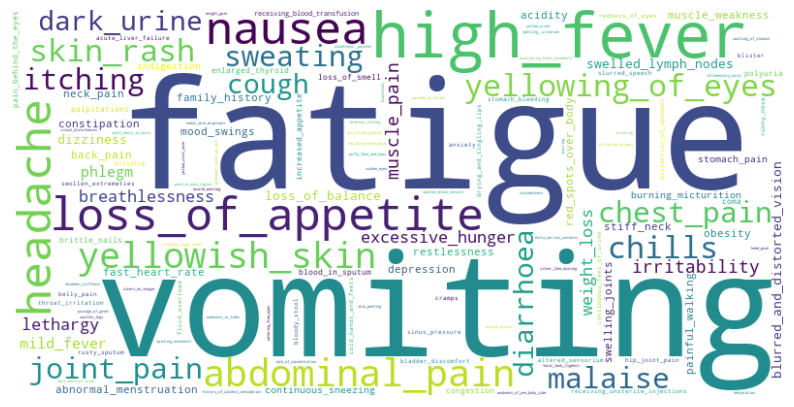

In [14]:
# Generate the word cloud using the symptom counts
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(symptom_counts)

# Plot the word cloud image
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### N-GRAMS
#### Extracting and Analyzing N-grams from Symptoms

In [15]:
# Drop the 'Disease' column and flatten the DataFrame to get a list of all symptom words
all_symptoms = df.drop(columns=['Disease']).values.flatten()

# Convert all values to strings and filter out the string representation of NaN (to clean the data)
all_symptoms = [str(s) for s in all_symptoms if str(s) != 'nan' and str(s) != 'NaN']

# Tokenize the symptoms: split each symptom at underscores to get individual words
tokens = list(chain.from_iterable([symptom.split('_') for symptom in all_symptoms]))

# Generate bi-grams (2 word combinations) and tri-grams (3 word combinations) from the token list
bi_grams = list(ngrams(tokens, 2))
tri_grams = list(ngrams(tokens, 3))

# Count frequencies of each bi-gram and tri-gram to identify most common combinations
bi_gram_counts = Counter(bi_grams)
tri_gram_counts = Counter(tri_grams)

### Bi-Grams
#### Visualizing Top Bi-grams from Symptoms

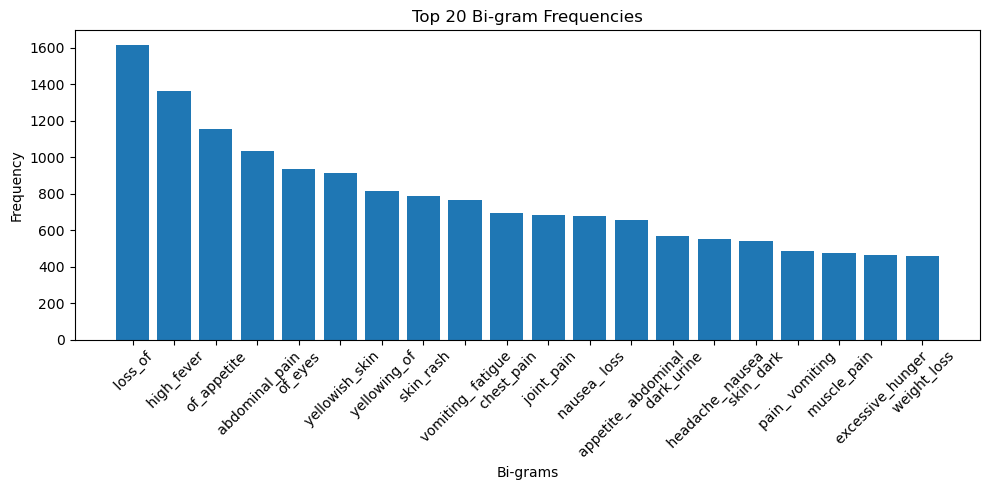

In [16]:
# Sort the bi_gram_counts dictionary by values (frequencies) in descending order and take top 20
top_20_bi_grams = dict(sorted(bi_gram_counts.items(), key=lambda item: item[1], reverse=True)[:20])

# Visualization of Top 20 Bi-grams
plt.figure(figsize=(10, 5))
plt.bar(['_'.join(bg) for bg in top_20_bi_grams.keys()], top_20_bi_grams.values())
plt.xlabel('Bi-grams')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.title('Top 20 Bi-gram Frequencies')
plt.tight_layout()
plt.show()

### Tri-Grams
#### Visualizing Top Tri-grams from Symptoms

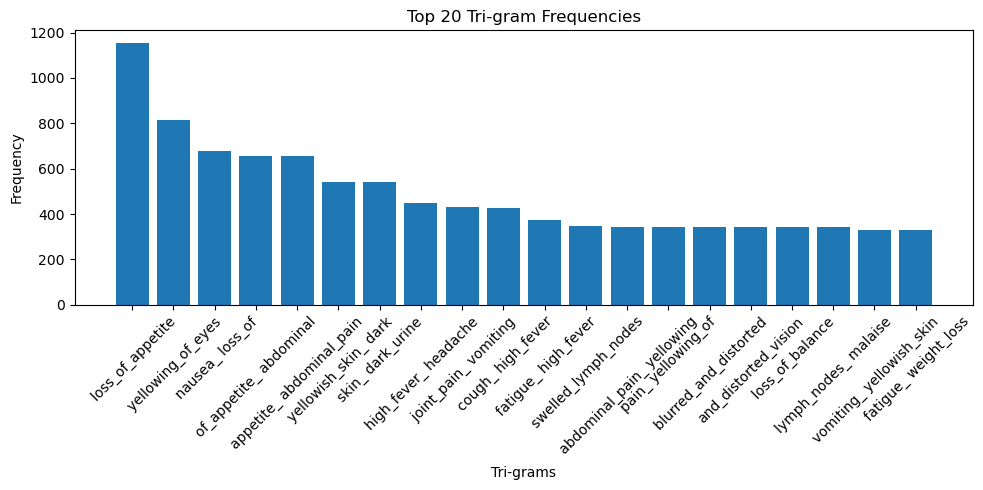

In [17]:
# Sort the tri_gram_counts dictionary by values (frequencies) in descending order and take top 20
top_20_tri_grams = dict(sorted(tri_gram_counts.items(), key=lambda item: item[1], reverse=True)[:20])

# Visualization of Top 20 Tri-grams
plt.figure(figsize=(10, 5))
plt.bar(['_'.join(tg) for tg in top_20_tri_grams.keys()], top_20_tri_grams.values())
plt.xlabel('Tri-grams')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.title('Top 20 Tri-gram Frequencies')
plt.tight_layout()
plt.show()

## N-grams summary

#### Bi-Grams (2-word combinations) Visualization:
- **Insights**:
  1. "Loss of" and "high fever" are the most frequently occurring bi-grams among the symptoms data.
  2. "Yellow eyes", "swollen lymph", and "rapid weight loss" are among the top bi-grams but have a significantly lower occurrence compared to the top two.
  3. Common symptoms like "joint pain", "muscle pain", and "vomiting" also appear as frequent bi-grams.
  4. The visualized data provides insights into commonly co-occurring symptoms or descriptors of symptoms.

#### Tri-Grams (3-word combinations) Visualization:
- **Insights**:
  1. "Loss of appetite" stands out as the most frequent tri-gram.
  2. "Eyes & yellowing", "high fever &", and "abdominal pain &" are other top tri-grams but with lesser frequencies.
  3. Tri-grams like "swollen lymph nodes", "burned & blurry vision", and "vomiting & diarrhea" provide insight into more detailed symptom descriptions or combinations of symptoms that often appear together.
  4. This chart gives a more refined view of how symptoms are often described or how they co-occur in the data.

### Summary:
The exploration of bi-grams and tri-grams from the symptoms data provides a nuanced understanding of the most frequent symptom combinations or descriptors. While "loss of appetite" is a dominant symptom described using tri-grams, "loss of" and "high fever" are significant when looking at bi-grams. Recognizing these patterns can be valuable for healthcare professionals or researchers in understanding common symptom combinations or for developing health-related questionnaires or surveys.

## Modeling

#### Encoding the Diseases

In [18]:
# Initializing the Label Encoder
disease_encoder = LabelEncoder()

# Fitting the encoder on the 'Disease' column of the training data
train['Disease_encoded'] = disease_encoder.fit_transform(train['Disease'])

# Transforming the 'Disease' column of validation and test data using the fitted encoder
val['Disease_encoded'] = disease_encoder.transform(val['Disease'])
test['Disease_encoded'] = disease_encoder.transform(test['Disease'])

# Encoding 'Disease'
disease_encoder = LabelEncoder()
df_final['Disease_encoded'] = disease_encoder.fit_transform(df_final['Disease'])

In [19]:
train.head()

,Disease,abdominal_pain,abnormal_menstruation,acidity,acute_liver_failure,altered_sensorium,anxiety,back_pain,belly_pain,blackheads,...,weakness_in_limbs,weakness_of_one_body_side,weight_gain,weight_loss,yellow_crust_ooze,yellow_urine,yellowing_of_eyes,yellowish_skin,itching,Disease_encoded
1345,Migraine,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,30
4572,Hepatitis C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,20
4755,Impetigo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,27
1912,Pneumonia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,34
55,Peptic ulcer diseae,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,33


#### Balancing Data:

##### Balancing the classes in our datasets by upsampling the minority class.

In [20]:
def balance_data(data):
    # Identify the majority class
    majority_class = data['Disease_encoded'].value_counts().idxmax()
    
    # Separate majority and minority classes
    data_majority = data[data.Disease_encoded == majority_class]
    data_minority = data[data.Disease_encoded != majority_class]
    
    # Upsample minority class
    data_minority_upsampled = resample(data_minority, 
                                       replace=True, 
                                       n_samples=len(data_majority),
                                       random_state=42)
    
    # Combine majority class with upsampled minority class
    data_balanced = pd.concat([data_majority, data_minority_upsampled])
    
    return data_balanced

In [21]:
# Apply the balancing function to the train, val, and test datasets
train_balanced = balance_data(train)
val_balanced = balance_data(val)
test_balanced = balance_data(test)

In [22]:
train_balanced.head()

,Disease,abdominal_pain,abnormal_menstruation,acidity,acute_liver_failure,altered_sensorium,anxiety,back_pain,belly_pain,blackheads,...,weakness_in_limbs,weakness_of_one_body_side,weight_gain,weight_loss,yellow_crust_ooze,yellow_urine,yellowing_of_eyes,yellowish_skin,itching,Disease_encoded
1345,Migraine,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,30
2161,Migraine,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,30
2717,Migraine,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,30
4480,Migraine,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,30
4685,Migraine,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,30


### Data split

#### Splitting Data into Features and Targets

##### Now that our datasets are balanced, we'll split each one into features and targets to prepare for modeling.

In [23]:
# Splitting balanced train dataset
X_train = train_balanced.drop(['Disease', 'Disease_encoded'], axis=1)
y_train = train_balanced['Disease_encoded']

# Splitting balanced validation dataset
X_val = val_balanced.drop(['Disease', 'Disease_encoded'], axis=1)
y_val = val_balanced['Disease_encoded']

# Splitting balanced test dataset
X_test = test_balanced.drop(['Disease', 'Disease_encoded'], axis=1)
y_test = test_balanced['Disease_encoded']

X = df_balanced.drop(['Disease', 'Disease_encoded'], axis=1)
y = df_balanced['Disease_encoded']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

### Classification Models

#### Baseline

In [24]:
# Baseline Model
clf_baseline = DummyClassifier(strategy="most_frequent", random_state=42)

# Train the baseline on the training data
clf_baseline.fit(X_train, y_train)

# Predict on the validation set
y_pred_baseline_val = clf_baseline.predict(X_val)

# Compute accuracy on the validation set
accuracy_baseline = accuracy_score(y_val, y_pred_baseline_val)
print(f"Baseline Accuracy: {accuracy_baseline:.4f}")

Baseline Accuracy: 0.0208



clf_baseline.fit(X_train, y_train)
y_pred_baseline = clf_baseline.predict(X_test)
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
accuracy_baseline

In [25]:
X_train.head()

,abdominal_pain,abnormal_menstruation,acidity,acute_liver_failure,altered_sensorium,anxiety,back_pain,belly_pain,blackheads,bladder_discomfort,...,watering_from_eyes,weakness_in_limbs,weakness_of_one_body_side,weight_gain,weight_loss,yellow_crust_ooze,yellow_urine,yellowing_of_eyes,yellowish_skin,itching
1345,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2161,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2717,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4480,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4685,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### RandomForest

In [26]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predicting and calculating accuracy on the training set
y_pred_train = clf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Training Accuracy (Random Forest): {train_accuracy:.4f}")

# Predicting and calculating accuracy on the validation set
y_pred_val = clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred_val)
print(f"Validation Accuracy (Random Forest): {val_accuracy:.4f}")

Training Accuracy (Random Forest): 1.0000
Validation Accuracy (Random Forest): 0.9583


### LogisticRegression

In [27]:
# Logistic Regression
clf_lr = LogisticRegression(max_iter=10000, random_state=42) # Increase max_iter for convergence
clf_lr.fit(X_train, y_train)

# Predicting and calculating accuracy on the training set
y_pred_train_lr = clf_lr.predict(X_train)
train_accuracy_lr = accuracy_score(y_train, y_pred_train_lr)
print(f"Training Accuracy (Logistic Regression): {train_accuracy_lr:.4f}")

# Predicting and calculating accuracy on the validation set
y_pred_val_lr = clf_lr.predict(X_val)
val_accuracy_lr = accuracy_score(y_val, y_pred_val_lr)
print(f"Validation Accuracy (Logistic Regression): {val_accuracy_lr:.4f}")

Training Accuracy (Logistic Regression): 1.0000
Validation Accuracy (Logistic Regression): 0.9583


### KNeighborsClassifier

In [28]:
# KNN
clf_knn = KNeighborsClassifier(n_neighbors=5)
clf_knn.fit(X_train, y_train)

# Predicting and calculating accuracy on the training set
y_pred_train_knn = clf_knn.predict(X_train)
train_accuracy_knn = accuracy_score(y_train, y_pred_train_knn)
print(f"Training Accuracy (KNN): {train_accuracy_knn:.4f}")

# Predicting and calculating accuracy on the validation set
y_pred_val_knn = clf_knn.predict(X_val)
val_accuracy_knn = accuracy_score(y_val, y_pred_val_knn)
print(f"Validation Accuracy (KNN): {val_accuracy_knn:.4f}")

Training Accuracy (KNN): 0.8819
Validation Accuracy (KNN): 0.3542


### Test

In [29]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predicting and calculating accuracy on the validation set
y_pred_test = clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy (Random Forest): {test_accuracy:.4f}")

Test Accuracy (Random Forest): 0.8958


In [30]:
# Save the predictions to a CSV file
prediction_df = pd.DataFrame({'Actual_Disease': y_test, 'Predicted_Disease': y_pred_test})
prediction_df.to_csv('predictions.csv', index=False)

# Save the test accuracy to a file (if needed)
with open('test_accuracy.txt', 'w') as f:
    f.write(f"Test Accuracy (Random Forest): {test_accuracy:.4f}")

Test Accuracy (Random Forest): 0.8958


In [31]:
import pandas as pd

# Read the prediction CSV file into a DataFrame
prediction_df = pd.read_csv('predictions.csv')

# Display the content of the DataFrame
print(prediction_df)


    Actual_Disease  Predicted_Disease
0               11                 11
1               11                 11
2               11                 11
3               11                 11
4               11                 11
5               11                 11
6               11                 11
7               11                 11
8               11                 11
9               11                 11
10              11                 11
11              11                 11
12              11                 11
13              11                 11
14              11                 11
15              11                 11
16              11                 11
17              11                 11
18              11                 11
19              11                 11
20              11                 11
21              11                 11
22              11                 11
23              11                 11
24              38                 38
25          

### Modeling Conclusion

The purpose of this modeling was to predict diseases based on the given symptoms. We evaluated several models, including Random Forest, Logistic Regression, and KNN, against a baseline model. Here's a summary of the results:

- **Baseline Model**:
  - Accuracy: 0.0208
  
  This low accuracy is expected since the baseline model predicts diseases based on the most frequent class without any true learning.

- **Random Forest**:
  - Training Accuracy: 1.0000
  - Validation Accuracy: 0.9583
  - Test Accuracy: 0.8958
  
  The Random Forest model performed remarkably well on the training dataset, achieving perfect accuracy. This indicates that it could potentially overfit to the training data. However, its high validation accuracy demonstrates that it generalizes fairly well to unseen data. The test accuracy further validates its robustness.

- **Logistic Regression**:
  - Training Accuracy: 1.0000
  - Validation Accuracy: 0.9583
  
  Similar to the Random Forest model, the Logistic Regression model also showed perfect accuracy on the training data and impressive performance on the validation set. This suggests that the model might have identified clear linear boundaries among the features.

- **KNN**:
  - Training Accuracy: 0.8819
  - Validation Accuracy: 0.3542
  
  The KNN model demonstrated satisfactory performance on the training data but showed a significant drop in accuracy on the validation set. This could imply that KNN isn't the best model for this type of data or the chosen hyperparameters are not optimal.

**Final Thoughts**:
The Random Forest and Logistic Regression models both achieved high accuracies on the validation set, indicating that they can be potential candidates for deployment. While both models achieved perfect training accuracy, which might suggest overfitting, their high validation accuracies counteract this concern. On the other hand, the KNN model might require further hyperparameter tuning or might not be suitable for this particular dataset.

Given the test accuracy of 0.8958 for the Random Forest model, it seems to be the most promising model for predicting diseases based on symptoms. Future work can explore ensemble methods, additional feature engineering, or more complex models to improve upon these results.